In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install tensorflow==2.15.0 --quiet
# !pip install mediapipe --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-serving-api 2.16.1 requires tensorflow<3,>=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.65 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    print("CUDA và GPU đang được sử dụng")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

    local_device_protos = device_lib.list_local_devices()
    gpu_list = [x.name for x in local_device_protos if x.device_type == 'GPU']
    print("List GPU:", gpu_list)
    print("CUDA version:", tf.sysconfig.get_build_info()['cuda_version'])
    print("cuDNN version:", tf.sysconfig.get_build_info()['cudnn_version'])
else:
    print("Không tìm thấy GPU hoặc TPU !!!")

2024-10-20 03:48:44.761587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 03:48:44.761667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 03:48:44.763107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
CUDA và GPU đang được sử dụng
1 Physical GPUs, 1 Logical GPUs
List GPU: ['/device:GPU:0']
CUDA version: 12.2
cuDNN version: 8


In [3]:
from glob import glob
import matplotlib.pyplot as plt
import cv2
import random
import pandas as pd
import os
from PIL import Image
import warnings
import gc
from skimage import io, img_as_ubyte
import numpy as np
import csv
import time
import seaborn as sns

from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Dropout, ConvLSTM2D, MaxPooling3D, LSTM
from tensorflow.keras.layers import MaxPooling2D, Activation, BatchNormalization, Reshape, TimeDistributed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# import mediapipe as mp

warnings.filterwarnings("ignore")

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

TensorFlow Version 2.15.0


# **Thêm Path dataset**

In [4]:
train_path = '/kaggle/input/jestet-processed-new/Train'
validation_path = '/kaggle/input/jestet-processed-new/Validation'

In [97]:
def check_videos_with_37_frames(base_path):
    videos_not_ok = []
    for label_dir in os.listdir(base_path):
        label_path = os.path.join(base_path, label_dir)
        if os.path.isdir(label_path):
            video_dirs = sorted(os.listdir(label_path))
            for video in video_dirs:
                video_path = os.path.join(label_path, video)
                frame_paths = sorted(glob(os.path.join(video_path, '*.jpg')))
                if len(frame_paths) != 37:
                    videos_not_ok.append((label_dir, video, len(frame_paths))) 
    if videos_not_ok:
        print("Các video không đủ 37 khung hình:")
        for label, video, frame_count in videos_not_ok:
            print(f"- Video '{video}' trong nhãn '{label}' chỉ có {frame_count} khung hình.")
    else:
        print("Tất cả các video đều có đủ 37 khung hình.")

check_videos_with_37_frames(train_path)

Tất cả các video đều có đủ 37 khung hình.


In [21]:
def count_videos_in_labels(base_path):
    label_video_count = {} 
    
    for label_dir in os.listdir(base_path):
        label_path = os.path.join(base_path, label_dir)
        
        if os.path.isdir(label_path):
            video_dirs = os.listdir(label_path)  
            label_video_count[label_dir] = len(video_dirs)  
            
    return label_video_count

print("Số lượng video/nhãn của tập Train:")
video_train_counts = count_videos_in_labels(train_path)
for label, count in video_train_counts.items():
    print(f"Nhãn '{label}' có {count} video.")
    
print("Số lượng video/nhãn của tập Validation:")
video_val_counts = count_videos_in_labels(validation_path)
for label, count in video_val_counts.items():
    print(f"Nhãn '{label}' có {count} video.")

Số lượng video/nhãn của tập Train:
Nhãn 'Stop Sign' có 1821 video.
Nhãn 'Thumb Up' có 1841 video.
Nhãn 'Sliding Two Fingers Down' có 1832 video.
Nhãn 'Shaking Hand' có 1789 video.
Nhãn 'Pulling Two Fingers In' có 1859 video.
Nhãn 'Sliding Two Fingers Up' có 1779 video.
Nhãn 'Swiping Left' có 1762 video.
Nhãn 'Thumb Down' có 1810 video.
Nhãn 'Swiping Right' có 1730 video.
Số lượng video/nhãn của tập Validation:
Nhãn 'Stop Sign' có 259 video.
Nhãn 'Thumb Up' có 238 video.
Nhãn 'Sliding Two Fingers Down' có 249 video.
Nhãn 'Shaking Hand' có 245 video.
Nhãn 'Pulling Two Fingers In' có 233 video.
Nhãn 'Sliding Two Fingers Up' có 244 video.
Nhãn 'Swiping Left' có 247 video.
Nhãn 'Thumb Down' có 250 video.
Nhãn 'Swiping Right' có 231 video.


# ***=======Main Create Dataset=========***

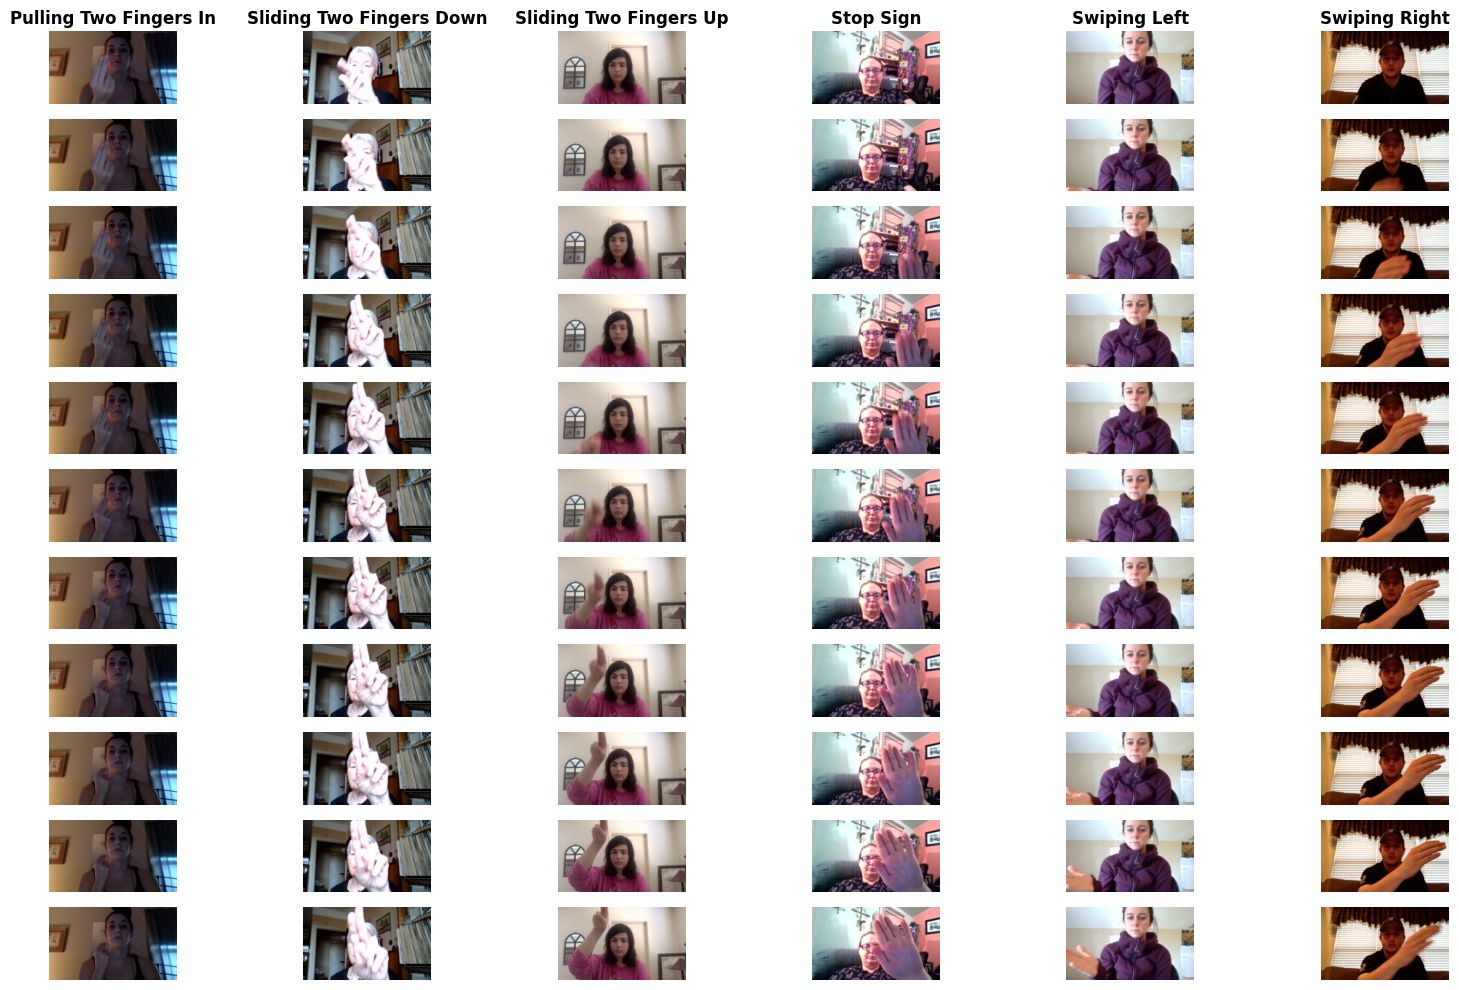

In [100]:
def display_original_frames_for_labels(base_path, start_frame=10, end_frame=20):
    labels = ["Sliding Two Fingers Down", "Sliding Two Fingers Up",
                "Stop Sign", "Swiping Left", "Swiping Right"]
    plt.figure(figsize=(15, 10))
    num_frames_to_display = end_frame - start_frame + 1
    num_labels = len(labels)

    for idx, label in enumerate(labels):
        label_path = os.path.join(base_path, label)
        if os.path.isdir(label_path):
            video_dirs = sorted(os.listdir(label_path))
            selected_video = video_dirs[0]
            video_path = os.path.join(label_path, selected_video)
            frame_paths = sorted(glob(os.path.join(video_path, '*.jpg'))) 

            for i in range(start_frame - 1, end_frame): 
                if i < len(frame_paths):  
                    img = plt.imread(frame_paths[i]) 
                    plt.subplot(num_frames_to_display, num_labels, (i - (start_frame - 1)) * num_labels + idx + 1) 
                    plt.imshow(img)
                    plt.axis('off')

                    if i == start_frame - 1:  
                        plt.text(0.5, 1.05, label, fontsize=12, ha='center', va='bottom', 
                                 fontweight='bold', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

display_original_frames_for_labels(validation_path)

In [5]:
height, width = 64, 64
size_img = (height, width)
num_frames = 19
per_data = 0.75
num_classes = 5
batch_size = 16

In [6]:
def preprocess_image(img_array):
#     img_array = cv2.convertScaleAbs(img_array, alpha=1, beta=30)  
#     img_array = cv2.convertScaleAbs(img_array, alpha=1.5, beta=0) 
#     gray_image = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
#     edges = cv2.Canny(gray_image, 100, 200)
#     edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  
#     img_array = cv2.addWeighted(img_array, 0.8, edges_colored, 0.2, 0)
    img_array = img_array / 255.0

    return img_array

In [7]:
def frame_extraction(video_path, num_frames):
    frame_paths = sorted(glob(os.path.join(video_path, '*.jpg')))
    selected_frames = frame_paths[::2]   

    frames = []
    for frame_path in selected_frames:
        img = image.load_img(frame_path, target_size=size_img)
        img_array = image.img_to_array(img)
        img_array = preprocess_image(img_array)
        frames.append(img_array)  

    return frames

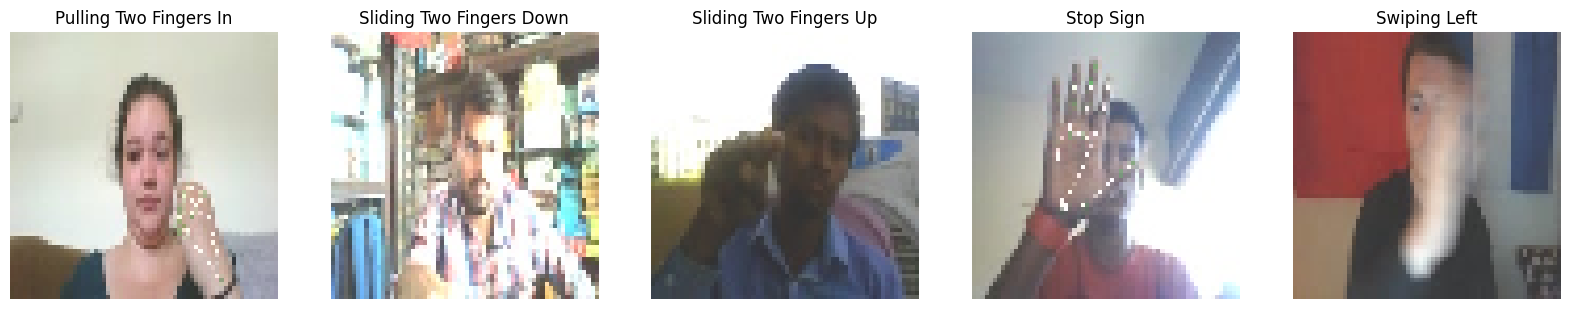

In [8]:
def display_random_images(subset_path, num_images=5):
    labels = [
        "Pulling Two Fingers In", 
        "Sliding Two Fingers Down", 
        "Sliding Two Fingers Up",
        "Stop Sign", 
        "Swiping Left", 
        "Swiping Right"
    ]
    
    label_mapping = {label: idx for idx, label in enumerate(labels)}
    features = {label: [] for label in labels}  # Tạo từ điển để lưu trữ mảng ảnh cho từng nhãn

    for label in label_mapping.keys():
        label_path = os.path.join(subset_path, label)
        if os.path.isdir(label_path):
            video_dirs = sorted(os.listdir(label_path))
            # Chọn một video ngẫu nhiên từ danh sách video
            if video_dirs:
                random_video = random.choice(video_dirs)
                video_path = os.path.join(label_path, random_video)
                if os.path.isdir(video_path):
                    frames = frame_extraction(video_path, num_frames)
                    features[label].extend(frames)  # Lưu khung hình vào mảng tương ứng với nhãn

    plt.figure(figsize=(20, 20))
    
    # Lặp qua mỗi nhãn và chọn một ảnh từ mảng ảnh tương ứng bắt đầu từ chỉ số 10
    for i, label in enumerate(label_mapping.keys()):
        if features[label] and len(features[label]) > 10:  # Kiểm tra nếu có đủ khung hình cho nhãn
            random_image = features[label][10]  # Lấy ảnh từ chỉ số 10
            plt.subplot(1, num_images, i + 1)
            plt.imshow(random_image)
            plt.title(label)  # Thêm tiêu đề là nhãn tương ứng
            plt.axis('off')  # Ẩn trục
        if i + 1 >= num_images:  # Dừng khi đã hiển thị đủ số ảnh yêu cầu
            break

    plt.show()

# Gọi hàm với đường dẫn đến tập hợp con chứa các video
display_random_images(train_path)

In [ ]:
# ======================= Dataset.from_generator spilit_ratio ==================================
def data_generator(subset_path, num_frames, per_data, num_classes, split_ratio=0.8):
    labels = {
        "Pulling Two Fingers In": 0, 
        "Sliding Two Fingers Down": 1,
        "Sliding Two Fingers Up": 2,
        "Stop Sign": 3, 
        "Swiping Left": 4, 
        "Swiping Right": 5
    }
    
    for label, label_index in labels.items():
        label_path = os.path.join(subset_path, label)
        if os.path.isdir(label_path):
            video_dirs = sorted(os.listdir(label_path))
            num_selected_videos = int(len(video_dirs) * per_data)
            
            # Tính số lượng video cho training và validation
            train_split = int(num_selected_videos * split_ratio)
            
            for idx, video_id in enumerate(video_dirs[:num_selected_videos]):
                video_path = os.path.join(label_path, video_id)
                if os.path.isdir(video_path):
                    frames = frame_extraction(video_path, num_frames)
                    one_hot_label = tf.one_hot(label_index, num_classes)
                    
                    # yield cho tập train hoặc val tùy vào index
                    if idx < train_split:
                        yield np.asarray(frames), one_hot_label, 'train'
                    else:
                        yield np.asarray(frames), one_hot_label, 'val'

def create_tf_dataset_from_generator(subset_path, num_frames, per_data, num_classes, split_ratio=0.8):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(subset_path, num_frames, per_data, num_classes, split_ratio),
        output_signature=(  
            tf.TensorSpec(shape=(num_frames, height, width, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.string) 
        )
    )
    return dataset

# Tách riêng filter và map thành các hàm
def filter_train(frames, label, split):
    return split == 'train'

def filter_val(frames, label, split):
    return split == 'val'

def map_fn(frames, label, split):
    return frames, label

dataset = create_tf_dataset_from_generator(train_path, num_frames, per_data, num_classes)

# Chia dataset theo giá trị 'train' và 'val'
train_dataset = dataset.filter(filter_train).map(map_fn)
val_dataset = dataset.filter(filter_val).map(map_fn)

# Shuffle, batch, prefetch
train_dataset = train_dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# for frames, label in train_dataset.take(1):
#     print("Batch frames shape:", frames.shape)
#     print("Batch labels shape:", label.shape)

# for frames, label in val_dataset.take(1):
#     print("Batch frames shape:", frames.shape)
#     print("Batch labels shape:", label.shape)


In [32]:
# ======================= Dataset.from_generator ==================================
# Tạo generator cho dữ liệu huấn luyện
def data_generator(subset_path, num_frames, per_data, num_classes):
    labels = {
        "Pulling Two Fingers In": 0, 
        "Sliding Two Fingers Down": 1,
        "Sliding Two Fingers Up": 2,
        "Stop Sign": 3, 
        "Swiping Left": 4, 
        "Swiping Right": 5
    }
    
    for label, label_index in labels.items():
        label_path = os.path.join(subset_path, label)
        if os.path.isdir(label_path):
            video_dirs = sorted(os.listdir(label_path))
            num_selected_videos = int(len(video_dirs) * per_data)

            for video_id in video_dirs[:num_selected_videos]:
                video_path = os.path.join(label_path, video_id)
                if os.path.isdir(video_path):
                    frames = frame_extraction(video_path, num_frames)
                    
                    one_hot_label = tf.one_hot(label_index, num_classes)
                    yield np.asarray(frames), one_hot_label
                    
def create_tf_dataset_from_generator(subset_path, num_frames, per_data, num_classes):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(subset_path, num_frames, per_data, num_classes),
        output_signature=(  
            tf.TensorSpec(shape=(num_frames, height, width, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
        )
    )
    return dataset

train_dataset = create_tf_dataset_from_generator(train_path, num_frames, per_data, num_classes)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = create_tf_dataset_from_generator(validation_path, num_frames, per_data, num_classes)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# for frames, label in train_dataset.take(1):
#     print("Batch frames shape:", frames.shape)
#     print("Batch labels shape:", label.shape)
#     print("Batch frames example:", frames[0])
#     print("Batch label example:", label[0])
    
# for frames, label in val_dataset.take(1):
#     print("Batch frames shape:", frames.shape)
#     print("Batch labels shape:", label.shape)
#     print("Batch frames example:", frames[0])
#     print("Batch label example:", label[0])

In [8]:
# ========================= Train_Test_Split =============================
def create_dataset(subset_path, num_frames, per_data):
    labels = ["Sliding Two Fingers Down", "Sliding Two Fingers Up",
                "Stop Sign", "Swiping Left", "Swiping Right"]
    label_mapping = {label: idx for idx, label in enumerate(labels)}
    features = []
    label_list = []
    for label in label_mapping.keys():
        label_path = os.path.join(subset_path, label)
        if os.path.isdir(label_path):
            video_dirs = sorted(os.listdir(label_path))
            num_videos = len(video_dirs)
            num_selected_videos = int(num_videos * per_data)
            
            for video_id in video_dirs[:num_selected_videos]:
                video_path = os.path.join(label_path, video_id)
                if os.path.isdir(video_path):
                    frames = frame_extraction(video_path, num_frames)
                    features.append(frames)
                    label_list.append(label_mapping[label]) 
    features = np.array(features) 
    labels = np.array(label_list)  
    
    return features, labels

df_features, df_labels = create_dataset(train_path, num_frames, per_data)
print(df_features.shape)
print(df_labels.shape)   

train_features, val_features, train_labels, val_labels = train_test_split(
    df_features, df_labels, test_size=0.2, random_state=42, stratify=df_labels, shuffle=True)

train_features = tf.convert_to_tensor(train_features, dtype=tf.float32)
val_features = tf.convert_to_tensor(val_features, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.int32)

print(f"Số lượng mẫu trong tập huấn luyện: {train_features.shape[0]}")
print(f"Số lượng mẫu trong tập kiểm tra: {val_features.shape[0]}")

(6691, 19, 64, 64, 3)
(6691,)
Số lượng mẫu trong tập huấn luyện: 5352
Số lượng mẫu trong tập kiểm tra: 1339


In [9]:
train_labels = tf.one_hot(train_labels, num_classes)
val_labels = tf.one_hot(val_labels, num_classes)

# **==============================**

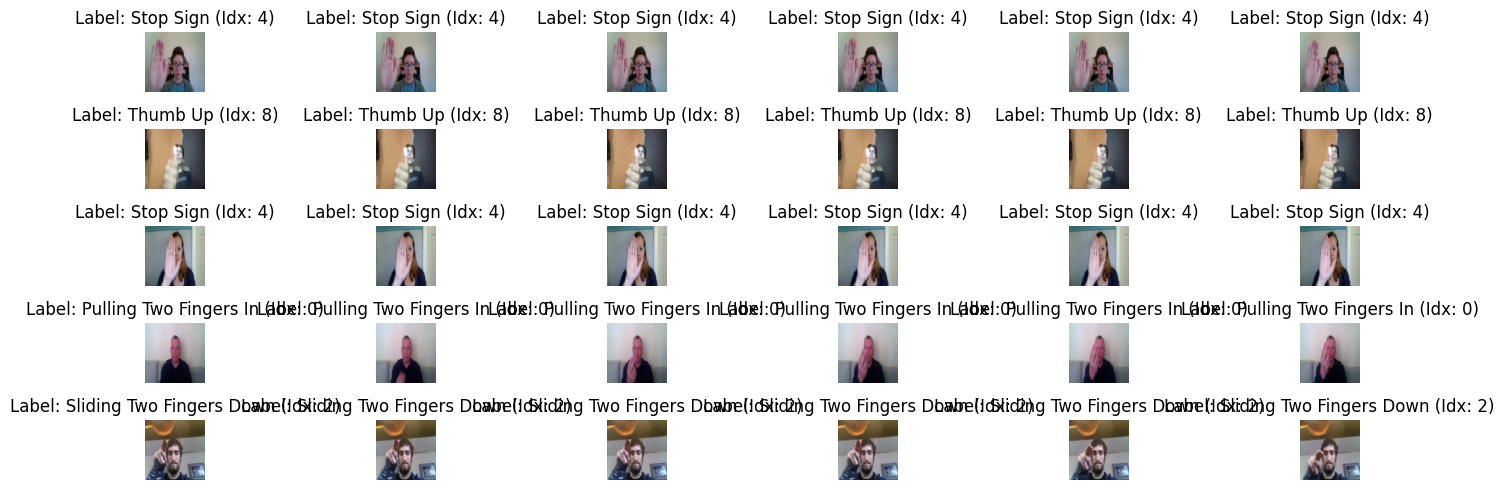

In [7]:
def show_random_videos(generator, num_videos_to_show=5, num_frames_to_start=0, num_frames_to_end=10):
    # Lấy ngẫu nhiên 3 video từ tập dataset
    random_video_indices = random.sample(range(len(generator.video_paths)), num_videos_to_show)
    
    plt.figure(figsize=(15, 5))
    
    for idx, video_idx in enumerate(random_video_indices):
        video_path = generator.video_paths[video_idx]
        
        # Lấy toàn bộ các frame từ video đã chọn
        frame_paths = sorted(glob(os.path.join(video_path, '*.jpg')))
        
        # Lấy các frame theo thứ tự
        ordered_frame_paths = frame_paths[num_frames_to_start:num_frames_to_end]
        
        # Lấy nhãn của video
        label_name = video_path.split('/')[-2]
        label_idx = generator.label_mapping[label_name]
        
        # Hiển thị các frame theo thứ tự
        num_frames_to_show = num_frames_to_end - num_frames_to_start
        for i, frame_path in enumerate(ordered_frame_paths):
            img = image.load_img(frame_path, target_size=size_img)
            plt.subplot(num_videos_to_show, num_frames_to_show, idx * num_frames_to_show + i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Label: {label_name} (Idx: {label_idx})")

    plt.tight_layout()
    plt.show()

# Gọi hàm show_random_videos để hiển thị 3 video ngẫu nhiên với các frame theo thứ tự
show_random_videos(train_gen, num_videos_to_show=5, num_frames_to_start=10, num_frames_to_end=16)

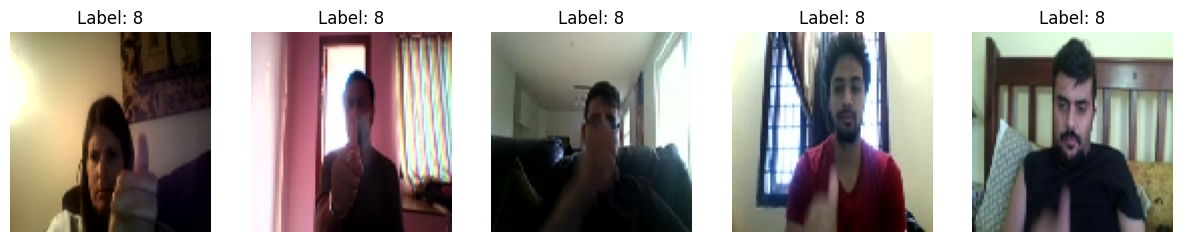

In [8]:
def display_random_samples(generator, num_samples=5):
    # Lấy ngẫu nhiên một nhãn từ label_mapping
    random_label_idx = random.choice(list(generator.label_mapping.values()))
    random_label_name = [name for name, idx in generator.label_mapping.items() if idx == random_label_idx][0]

    # Tìm tất cả video thuộc nhãn ngẫu nhiên
    label_videos = [video for video in generator.video_paths if random_label_name in video]

    # Lưu trữ các khung hình và nhãn
    samples = []

    for _ in range(num_samples):
        # Chọn ngẫu nhiên một video trong các video thuộc nhãn đã chọn
        random_video_path = random.choice(label_videos)

        # Lấy tất cả các khung hình của video
        frame_paths = sorted(glob(os.path.join(random_video_path, '*.jpg')))
        
        # Chọn ngẫu nhiên một khung hình từ video
        random_frame_path = random.choice(frame_paths)
        img = image.load_img(random_frame_path, target_size=size_img)  
        img_array = image.img_to_array(img)
        img_array = generator.preprocess_image(img_array)  # Tiền xử lý hình ảnh

        # Lưu khung hình và nhãn vào samples
        label = tf.constant(generator.label_mapping[random_label_name])
        samples.append((img_array, label.numpy()))

    # Hiển thị các mẫu
    plt.figure(figsize=(15, 5))
    for i, (img_array, label) in enumerate(samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_array)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Gọi hàm để hiển thị các mẫu ngẫu nhiên từ tập huấn luyện
display_random_samples(train_gen, num_samples=5)

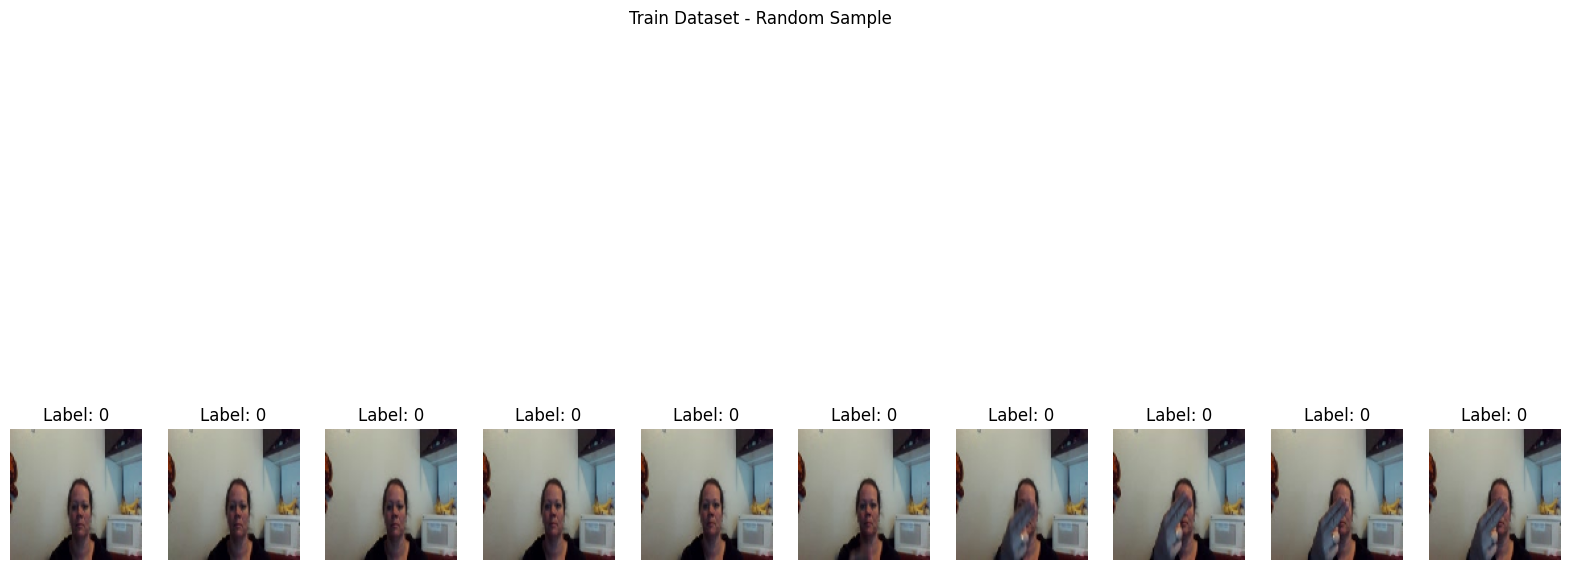

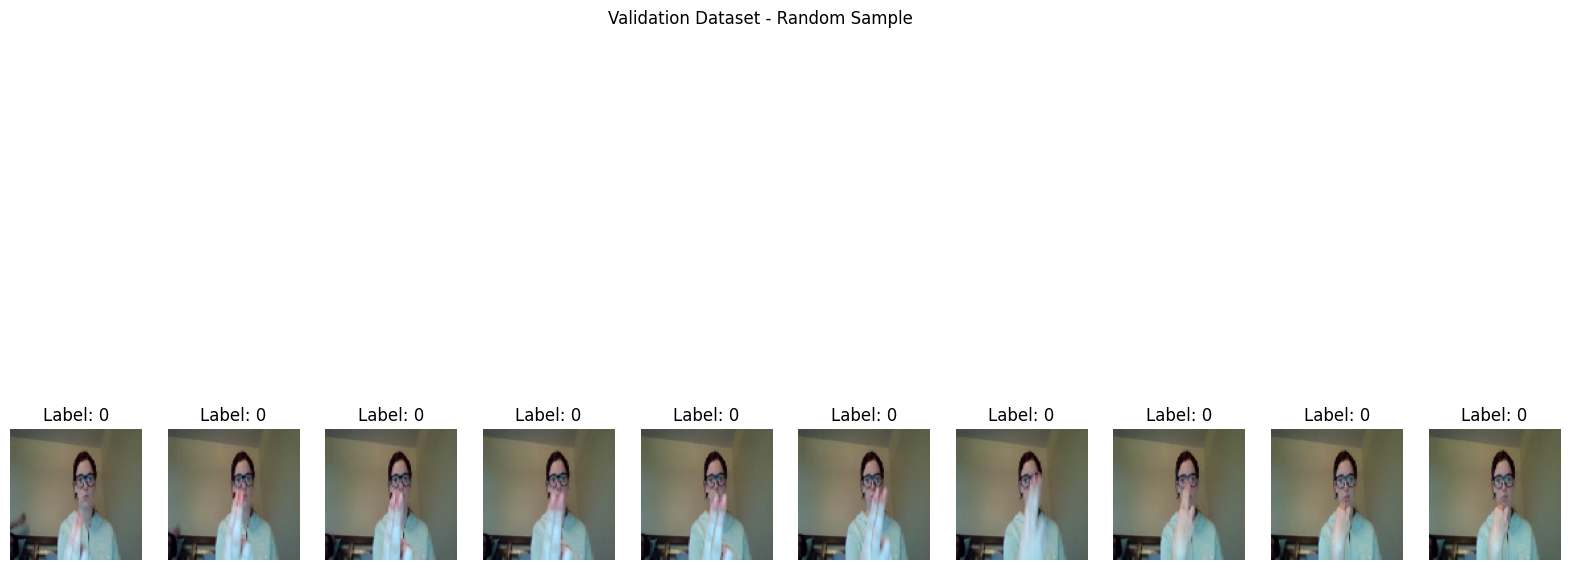

In [9]:
# Hàm hiển thị ảnh từ tensor
def plot_frames(batch_frames, batch_labels, title):
    plt.figure(figsize=(20, 10))
    num_videos_to_show = min(len(batch_frames), 1)  # Hiển thị tối đa 2 video
    num_frames_to_show = min(len(batch_frames[0]), 10)  # Sử dụng len để lấy số lượng frame

    for video_idx in range(num_videos_to_show):
        frames = batch_frames[video_idx]  # Lấy frames cho video thứ `video_idx`
        label = batch_labels[video_idx]  # Nhãn là số nguyên

        for frame_idx in range(num_frames_to_show):
            plt.subplot(num_videos_to_show, num_frames_to_show, video_idx * num_frames_to_show + frame_idx + 1)
            single_frame = (frames[frame_idx] * 255).astype("uint8")  # Chuyển đổi tensor thành ảnh uint8
            plt.imshow(single_frame)
            plt.title(f"Label: {label}")  # Ghi chú nhãn
            plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

# Hiển thị ngẫu nhiên 2 tập ảnh 
try:
    train_data = next(train_gen)  
    plot_frames(train_data[0], train_data[1], title="Train Dataset - Random Sample")
except StopIteration:
    print("Đã hết dữ liệu trong train_gen.")

try:
    val_data = next(val_gen) 
    plot_frames(val_data[0], val_data[1], title="Validation Dataset - Random Sample")
except StopIteration:
    print("Đã hết dữ liệu trong val_gen.")

In [10]:
# Lấy dữ liệu từ generator và tạo dataset
def create_dataset(generator, batch_size):
    frames_list = []
    labels_list = []
    
    # Lặp qua generator để thu thập batch dữ liệu
    for batch_frames, batch_labels in generator:
        frames_list.append(batch_frames) 
        labels_list.append(batch_labels) 
    
    # Chuyển các danh sách thành numpy array
    frames_array = np.concatenate(frames_list, axis=0)  
    labels_array = np.concatenate(labels_list, axis=0) 
    
    # Tạo dataset từ numpy array
    ds = tf.data.Dataset.from_tensor_slices((frames_array, labels_array))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_gen, batch_size)
val_ds = create_dataset(val_gen, batch_size)

# Kiểm tra dữ liệu đầu vào
for image_batch, label_batch in train_ds.take(1):
    print("Kích thước hình ảnh:", image_batch.shape)
    print("Hình ảnh mẫu:", image_batch[0])  
    print("Kích thước nhãn:", label_batch.shape)
    print("Nhãn mẫu:", label_batch.numpy()[0])  

Kích thước hình ảnh: (6, 19, 100, 100, 3)
Hình ảnh mẫu: tf.Tensor(
[[[[0.8        0.7490196  0.7137255 ]
   [0.80784315 0.75686276 0.72156864]
   [0.77254903 0.72156864 0.6862745 ]
   ...
   [0.6627451  0.5882353  0.59607846]
   [0.6627451  0.5882353  0.59607846]
   [0.6627451  0.5882353  0.59607846]]

  [[0.7921569  0.7411765  0.7058824 ]
   [0.8        0.7490196  0.7137255 ]
   [0.76862746 0.7176471  0.68235296]
   ...
   [0.6509804  0.5803922  0.5803922 ]
   [0.654902   0.5764706  0.58431375]
   [0.6509804  0.5764706  0.58431375]]

  [[0.78431374 0.73333335 0.69803923]
   [0.7921569  0.7411765  0.7058824 ]
   [0.7607843  0.70980394 0.6745098 ]
   ...
   [0.6431373  0.5647059  0.5686275 ]
   [0.64705884 0.56078434 0.5686275 ]
   [0.6431373  0.5647059  0.5686275 ]]

  ...

  [[0.54901963 0.47843137 0.43137255]
   [0.54509807 0.4745098  0.42745098]
   [0.54901963 0.47843137 0.43137255]
   ...
   [0.5137255  0.47843137 0.4509804 ]
   [0.5058824  0.47058824 0.44313726]
   [0.5019608  0.4

In [11]:
train_video_count = train_gen.count_videos()
val_video_count = val_gen.count_videos()

print(f"Số lượng video của {per_data * 100}% dataset:")
print(f"Số lượng video trong tập train: {train_video_count}")
print(f"Số lượng video trong tập validation: {val_video_count}")

Số lượng video của 20.0% dataset:
Số lượng video trong tập train: 3241
Số lượng video trong tập validation: 435


In [12]:
for images, labels in train_ds.take(1):  
    print("Kích thước batch train:")
    print("Hình ảnh:", images.shape)  
    print("Nhãn:", labels.shape)  

for images, labels in val_ds.take(1):  
    print("Kích thước batch validation:")
    print("Hình ảnh:", images.shape)  
    print("Nhãn:", labels.shape) 

Kích thước batch train:
Hình ảnh: (6, 19, 100, 100, 3)
Nhãn: (6,)
Kích thước batch validation:
Hình ảnh: (6, 19, 100, 100, 3)
Nhãn: (6,)


# **Lưu thời gian train mỗi epoch**

In [10]:
class TimeHistory(tf.keras.callbacks.Callback):
    def __init__(self, train_time_path):
        super(TimeHistory, self).__init__()
        self.train_time_path = train_time_path
        self.times = []
        self.epoch_start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.epoch_start_time
        self.times.append(elapsed_time)
        
        with open(self.train_time_path, 'a', newline='') as f:
            writer = csv.writer(f)
            if f.tell() == 0:  
                writer.writerow(['epoch', 'time'])
            writer.writerow([epoch, elapsed_time])

# **Build Model**

# **Model Conv2D + LSTM**

In [13]:
def create_mobile_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(layers.InputLayer(input_shape=input_shape))

    base_model = tf.keras.applications.EfficientNetB0(input_shape=(height, width, 3), 
                                                  include_top=False, 
                                                  weights='imagenet')

    
    model.add(TimeDistributed(base_model))
    model.add(BatchNormalization()) 
    
    model.add(TimeDistributed(layers.GlobalAveragePooling2D()))
    model.add(BatchNormalization()) 
    model.add(Dropout(0.2))  
    
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization()) 
    model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.2))
    model.add(BatchNormalization()) 
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False, recurrent_dropout=0.3))
    model.add(BatchNormalization()) 
    model.add(Dropout(0.1))
    
    model.add(Dense(128, activation='relu'))  
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu')) 
    model.add(Dropout(0.1))  
    model.add(Dense(num_classes, activation='softmax')) 

    return model

input_shape = (num_frames, height, width, 3)
num_classes = 6

model = create_mobile_lstm_model(input_shape, num_classes)

16705208/16705208 [==============================] - 0s 0us/step


In [41]:
def create_convlstm_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(layers.InputLayer(input_shape=input_shape))
    
    model.add(TimeDistributed(Conv2D(12, (2, 2), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2)))) 
#     model.add(BatchNormalization())
#     model.add(TimeDistributed(Dropout(0.15)))
    
    model.add(TimeDistributed(Conv2D(50, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.15)))
    
    model.add(TimeDistributed(Conv2D(96, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.2)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(8, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(LSTM(24, return_sequences=False))
    model.add(Dropout(0.15))
                  
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(num_classes, activation = "softmax"))
    
    return model

input_shape = (num_frames, height, width, 3)
num_classes = 5

model = create_convlstm_model(input_shape, num_classes)

# **============Main Model============**

In [ ]:
model.summary()

# Callback sớm dừng để ngừng huấn luyện sớm khi không cải thiện
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
)

# Tạo đối tượng ModelCheckpoint
best_model_filepath = './model/best_model.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        best_model_filepath,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

time_log_path = '/kaggle/working/model/train_time_epoch.csv'
csv_log_path = '/kaggle/working/model/training_log.csv'

if os.path.exists(time_log_path):
    os.remove(time_log_path)
    print(f"Đã xóa file: {time_log_path}")
if os.path.exists(csv_log_path):
    os.remove(csv_log_path)
    print(f"Đã xóa file: {csv_log_path}")

time_callback = TimeHistory(time_log_path)
csv_logger = CSVLogger(csv_log_path, append=False, separator=';')

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 19, 64, 64, 6)     150       
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 9, 32, 32, 6)      0         
 ng3D)                                                           
                                                                 
 dropout_69 (Dropout)        (None, 9, 32, 32, 6)      0         
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 32, 32, 32)     5216      
                                                                 
 max_pooling3d_13 (MaxPooli  (None, 4, 16, 16, 32)     0         
 ng3D)                                                           
                                                                 
 dropout_70 (Dropout)        (None, 4, 16, 16, 32)   

In [ ]:
plot_model(model, to_file='./model/model_diagram.png', show_shapes=True, show_layer_names=True)

In [ ]:
# ================= Train with Dataset From_generate =================
history = model.fit(train_dataset,
                    validation_data=val_dataset,  
                    epochs=30,
                    callbacks=[model_checkpoint, early_stopping_callbacks, csv_logger, time_callback])

Epoch 1/30
    674/Unknown - 512s 695ms/step - loss: 0.9040 - accuracy: 0.6823
Epoch 1: val_loss improved from inf to 4.20824, saving model to ./model/best_model.h5
674/674 [==============================] - 574s 787ms/step - loss: 0.9040 - accuracy: 0.6823 - val_loss: 4.2082 - val_accuracy: 0.1579
Epoch 2/30


In [ ]:
# ================= Train with Dataset Split =================
history = model.fit(x=train_features,
                    y=train_labels,  
                    validation_data=(val_features, val_labels),  
                    epochs=80,
                    batch_size=16, 
                    callbacks=[model_checkpoint, csv_logger, time_callback]
)

Epoch 1/80
335/335 [==============================] - ETA: 0s - loss: 1.6587 - accuracy: 0.2166
Epoch 1: val_loss improved from inf to 1.60997, saving model to ./model/best_model.h5
335/335 [==============================] - 14s 34ms/step - loss: 1.6587 - accuracy: 0.2166 - val_loss: 1.6100 - val_accuracy: 0.2114
Epoch 2/80
333/335 [============================>.] - ETA: 0s - loss: 1.4967 - accuracy: 0.3288
Epoch 2: val_loss improved from 1.60997 to 1.44174, saving model to ./model/best_model.h5
335/335 [==============================] - 10s 31ms/step - loss: 1.4942 - accuracy: 0.3303 - val_loss: 1.4417 - val_accuracy: 0.3092
Epoch 3/80
333/335 [============================>.] - ETA: 0s - loss: 0.7782 - accuracy: 0.7063
Epoch 3: val_loss improved from 1.44174 to 0.62357, saving model to ./model/best_model.h5
335/335 [==============================] - 11s 31ms/step - loss: 0.7769 - accuracy: 0.7068 - val_loss: 0.6236 - val_accuracy: 0.7872
Epoch 4/80
333/335 [===========================

In [44]:
model_path = '/kaggle/working/model/last_model.h5'
        
# Lưu mô hình đã huấn luyện
model.save(model_path)
print("Model created")

Model created


42/42 [==============================] - 3s 25ms/step
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       275
           1       0.76      0.79      0.78       267
           2       0.93      0.88      0.90       273
           3       0.82      0.77      0.80       264
           4       0.80      0.80      0.80       260

    accuracy                           0.81      1339
   macro avg       0.81      0.81      0.81      1339
weighted avg       0.81      0.81      0.81      1339



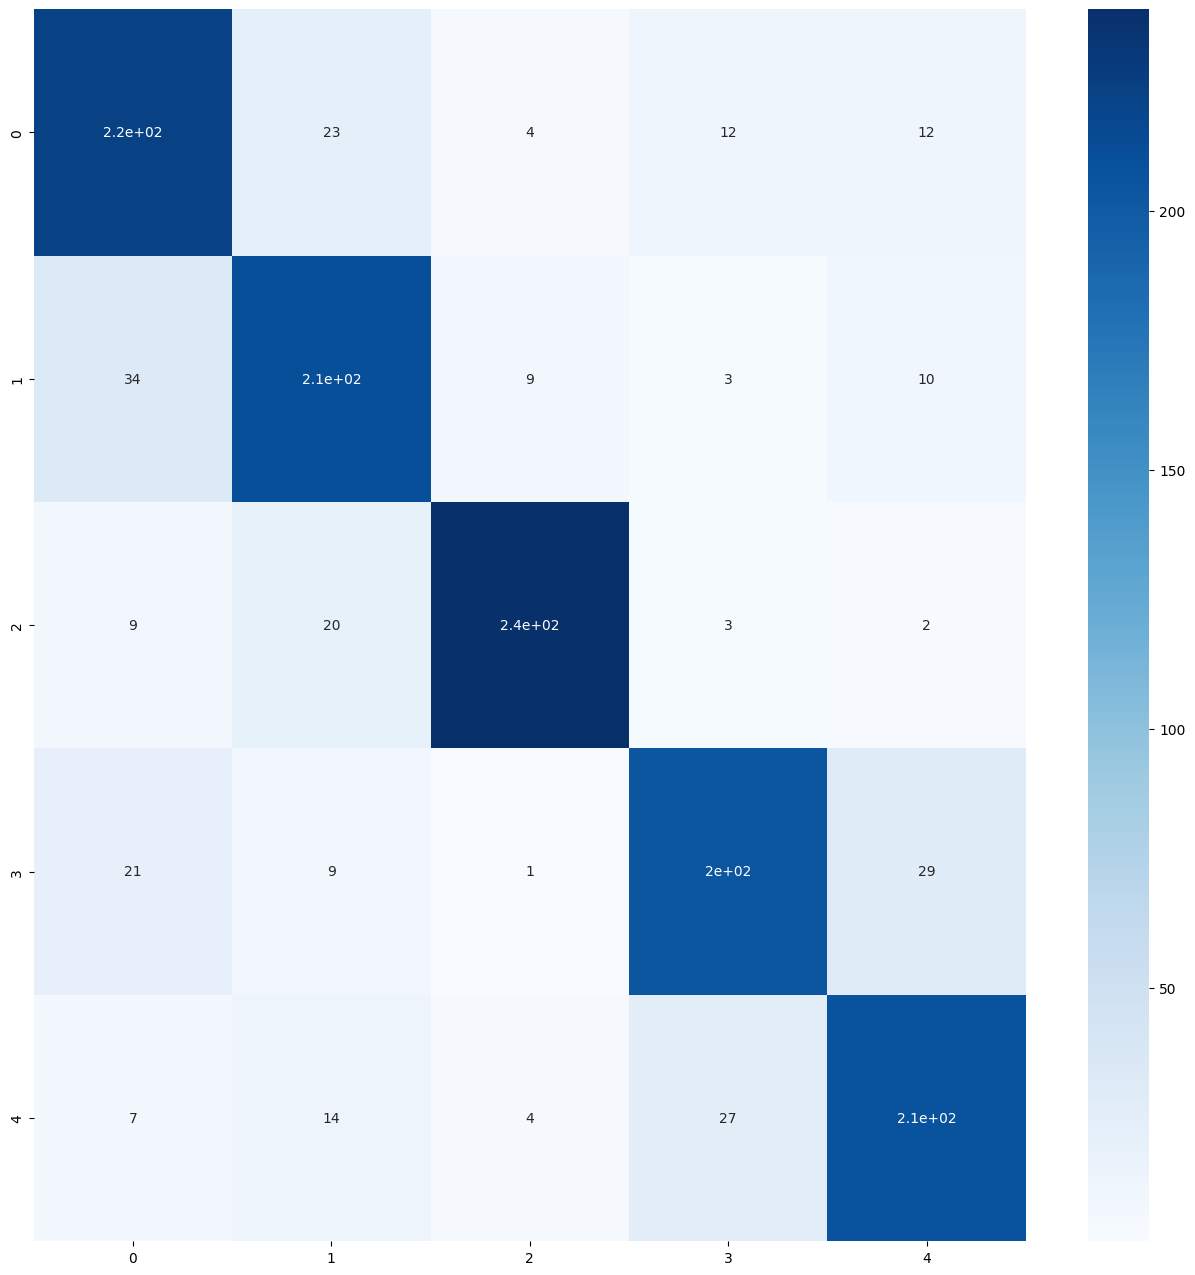

In [45]:
best_model = tf.keras.models.load_model('/kaggle/working/model/best_model.h5')

# Nếu val_labels đang ở dạng one-hot encoded, chuyển nó thành dạng nhãn đơn
if len(val_labels.shape) > 1 and val_labels.shape[1] > 1:
    true_classes = np.argmax(val_labels, axis=1)
else:
    true_classes = np.array(val_labels)

# Dự đoán các lớp từ val_features
predicted_classes = np.argmax(best_model.predict(val_features), axis=1)

# Hiển thị confusion matrix
confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(16, 16))
sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True)

# Lưu ma trận nhầm lẫn
output_path_conf = '/kaggle/working/model/conf_matrix.png'
plt.savefig(output_path_conf)

# In classification report
print(classification_report(true_classes, predicted_classes))

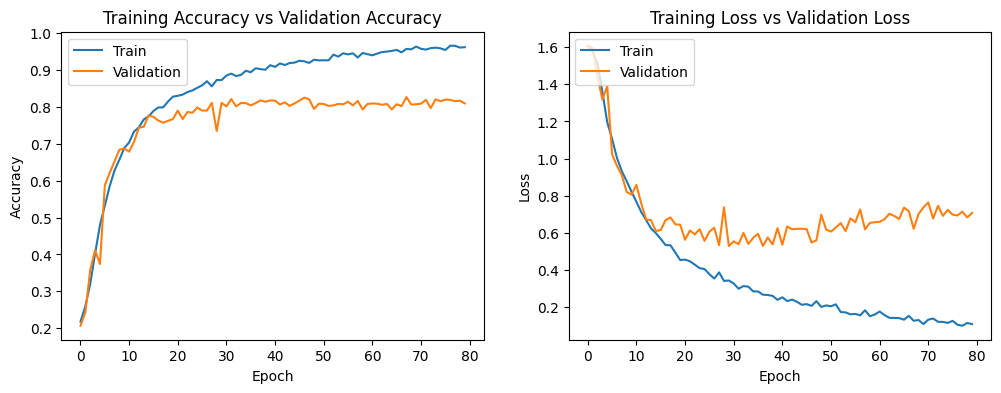

In [46]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

output_path_trainhis = '/kaggle/working/model/training_his.png' 
plt.savefig(output_path_trainhis)

plt.show()

# **Model Conv3D**

In [ ]:
def create_c3d_model(num_classes, input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    model.add(layers.Conv3D(filters=12, kernel_size=(2, 2, 2), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.15))

    model.add(layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.15))

    model.add(layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv3D(filters=40, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=20, activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=10, activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    return model

input_shape = (num_frames, height, width, 3)
num_classes = 5
    
model = create_c3d_model(num_classes, input_shape)

# **Model ConvLSTM2D**

In [ ]:
def create_convlstm2d_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(layers.InputLayer(input_shape=input_shape))
    
    model.add(ConvLSTM2D(filters = 12, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 50, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(layers.Dense(units=8, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=16, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(num_classes, activation = "softmax"))
    
    return model

input_shape = (num_frames, height, width, 3)
num_classes = 6
    
model = create_convlstm2d_model(input_shape, num_classes)